## Klassifikation menschlicher Aktivitäten mittels klassischer Machine-Learning-Modelle


In diesem Part dieses Projekts werden klassische Machine-Learning-Modelle auf sensorbasierten Zeitreihendaten angewandt, um menschliche Aktivitäten – konkret: Gehen (walk), Laufen (run) und Ruhe (sitting) – zu klassifizieren. 

Die ausgewählten Algorithmen sind:

- Random Forest
- Support Vector Machine (SVM)
- K-Nearest Neighbors (KNN)

Ziel dieser Analyse ist es, die drei Modelle anhand strukturierter Metriken (Accuracy, Precision, Recall, F1-Score) zu vergleichen und mindestens 90 % Genauigkeit zu erreichen.

### Teil 1: Vorbereitung

Im ersten Schritt bereite ich die Daten für das Trainieren unserer Modelle vor. Ziel ist es, eine saubere und konsistente Eingabematrix für die Klassifikation zu erzeugen. Dazu zählen das Einlesen der vorverarbeiteten Zeitfensterdaten, die Aufteilung in Trainings- und Testdatensatz sowie eine Standardisierung der Eingabefeatures. Zustätzlich befinden sich in diesem Teil alle imports für dieses Notebook.

In [12]:
import sys
import os
import pandas as pd
import rootutils
import numpy as np

np.random.seed(123)

root = rootutils.setup_root(search_from=".", indicator=".git")

DATA_DIR = root / "data" / "NDL"

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
import utils

print(dir(utils)) # debugging line to check if utils is imported correctly



['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'accuracy_score', 'compute_metrics', 'f1_score', 'learning_curve', 'np', 'plot_learning_curve', 'plot_metrics', 'plot_performance_metrics', 'plt', 'precision_score', 'print_compute_metrics', 'recall_score', 'test_no_data_leakage']


In [13]:
df = pd.read_csv(DATA_DIR / "features_non_dl.csv")
df.head(2)

,seconds_elapsed_mean,seconds_elapsed_std,seconds_elapsed_min,seconds_elapsed_max,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_min,accelerometer_x_max,accelerometer_y_mean,accelerometer_y_std,...,orientation_qy_mean,orientation_qy_std,orientation_qy_min,orientation_qy_max,orientation_qz_mean,orientation_qz_std,orientation_qz_min,orientation_qz_max,label,file
0,10.520981,1.452861,8.043650,13.002332,-0.582010,4.914281,-9.805667,8.643941,1.118579,2.992778,...,0.536875,0.029110,0.470338,0.612379,-0.679763,0.065264,-0.787285,-0.581134,walking,walking_9-2025-05-06_12-22-52.parquet
1,13.521103,1.449173,11.036159,15.996504,-0.225931,5.009952,-9.563337,8.643941,0.952118,2.940641,...,0.530289,0.040098,0.448271,0.614247,-0.666344,0.065198,-0.787285,-0.562609,walking,walking_9-2025-05-06_12-22-52.parquet


#### Teil 1.1: Datenaufbereitung
In diesem Zwischenschritt wird der vollständige Datensatz in zwei Teilmengen aufgeteilt: **80 % Trainingsdaten und 20 % Testdaten**. Diese Aufteilung ermöglicht eine zuverlässige Modellentwicklung: Das Modell wird auf den Trainingsdaten trainiert, während die Testdaten zur unabhängigen Bewertung der finalen Modellleistung dienen.

Zusätzlich werden in diesem Schritt die *Features* (**X**) und das *Zielmerkmal* (**y**) definiert. Das nicht für das Training relevante Attribut 'file' wird dabei entfernt.

In [14]:
from sklearn.model_selection import train_test_split

# Ursprüngliche Aufteilung
X = df.drop(['label', 'file'], axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42,
)

# Test auf Data Leakage
utils.test_no_data_leakage(df, X_train, X_test, y_train, y_test)

Kein Data Leakage entdeckt: Train/​Test-Indizes sind disjunkt und entsprechen dem Original-Index.


#### Teil 1.2 Datenexploration

In diesem Schritt wird der Datensatz einer explorativen Analyse unterzogen, um ein grundlegendes Verständnis für dessen Struktur, die Verteilung der Zielvariable, Merkmalsverteilungen sowie potenzielle Ausreißer zu erlangen. Ziel ist es, frühzeitig Auffälligkeiten zu identifizieren, die Klassifizierbarkeit der Daten einzuschätzen und möglichen Verzerrungen in späteren Modellierungsphasen vorzubeugen.

Darüber hinaus wird mithilfe eines Scree-Plots eine Hauptkomponentenanalyse (PCA) durchgeführt, um die bedeutendsten Dimensionen im Datensatz zu ermitteln. Dabei wird untersucht, welche Hauptkomponenten gemeinsam mindestens 95 % der Gesamtvarianz erklären.

Verteilung der Zielklassen:


,Anteil
label,
climbing,0.387987
walking,0.211189
sitting,0.207314
joggen,0.193509


/var/folders/j2/hs173s6n7nvcc39fpk2cyhm80000gn/T/ipykernel_58046/3913377521.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="pastel")


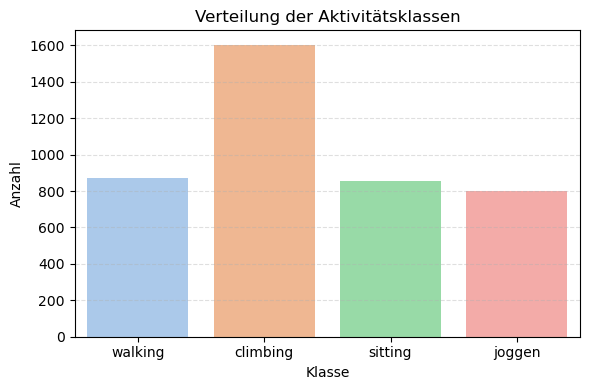

,count,mean,std,min,25%,50%,75%,max
seconds_elapsed_mean,4129.0,293.902235,334.035599,10.512946,73.516918,136.521012,436.542114,1237.582441
seconds_elapsed_std,4129.0,1.451622,0.001330,1.448746,1.450559,1.451950,1.452790,1.453721
seconds_elapsed_min,4129.0,291.422237,334.035584,8.036666,71.038064,134.039361,434.065403,1235.100510
seconds_elapsed_max,4129.0,296.382253,334.035599,12.995819,75.998617,139.000165,439.025107,1240.058730
accelerometer_x_mean,4129.0,-0.600268,0.994150,-4.141718,-0.488817,-0.194941,0.000729,0.592401
...,...,...,...,...,...,...,...,...
orientation_qy_max,4129.0,0.240312,0.575314,-0.677949,-0.396360,0.474453,0.750599,0.996222
orientation_qz_mean,4129.0,0.056348,0.500781,-0.743688,-0.509222,0.059057,0.587114,0.884167
orientation_qz_std,4129.0,0.056600,0.038382,0.000044,0.033450,0.061600,0.078664,0.413254
orientation_qz_min,4129.0,-0.046360,0.500693,-0.828259,-0.631842,0.044467,0.457908,0.808915


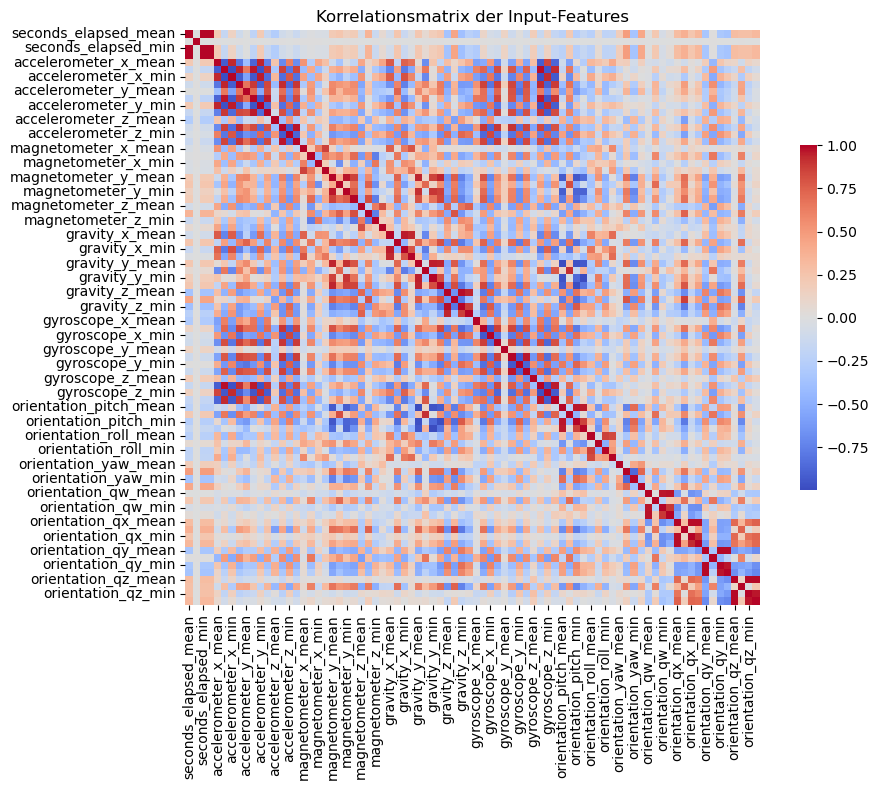

Fehlende Werte pro Spalte:


Series([], dtype: int64)

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Überblick über die Zielklassen
print("Verteilung der Zielklassen:")
display(y.value_counts(normalize=True).rename("Anteil").to_frame())

# Plot: Zielverteilung
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette="pastel")
plt.title("Verteilung der Aktivitätsklassen")
plt.ylabel("Anzahl")
plt.xlabel("Klasse")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show();

# Grundlegende Statistik der Features
display(X.describe().T)

# Korrelation der Features (stark korrelierte Features identifizieren)
plt.figure(figsize=(10, 8))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": .6})
plt.title("Korrelationsmatrix der Input-Features")
plt.tight_layout()
plt.show();

# Prüfung auf fehlende Werte
missing = df.isnull().sum()
print("Fehlende Werte pro Spalte:")
display(missing[missing > 0])

Totale ursprüngliche Features : 80
Reduziert auf Hauptkomponenten: 19
Erklärte Varianz durch PCA    : 0.9560


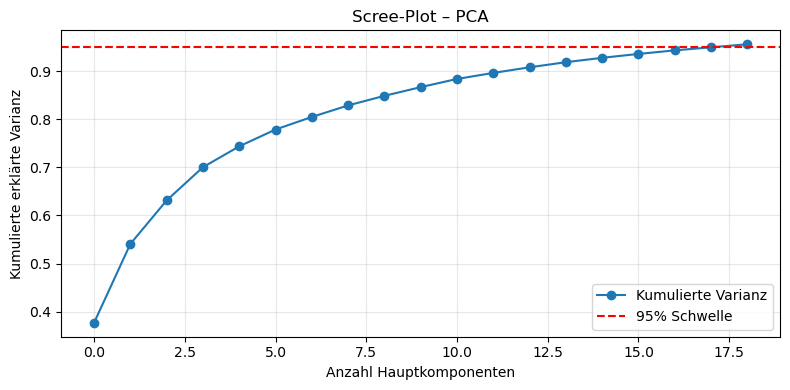

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 1. Daten skalieren
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2. PCA mit Varianz-Schwelle
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# 3. Informationen zur Reduktion
total_features = X_train.shape[1]
retained_components = pca.n_components_
explained_variance = np.sum(pca.explained_variance_ratio_)

print(f"Totale ursprüngliche Features : {total_features}")
print(f"Reduziert auf Hauptkomponenten: {retained_components}")
print(f"Erklärte Varianz durch PCA    : {explained_variance:.4f}")

# 4. Scree-Plot (kumulative erklärte Varianz)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', label='Kumulierte Varianz')
plt.axhline(0.95, color='red', linestyle='--', label='95% Schwelle')
plt.xlabel("Anzahl Hauptkomponenten")
plt.ylabel("Kumulierte erklärte Varianz")
plt.title("Scree-Plot – PCA")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
import pandas as pd

# Ladungsmatrix: 
loadings = pd.DataFrame(
    pca.components_,                # shape: (n_components, n_features)
    columns=X_train.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Absolutwerte zur Bewertung des Einflusses (je höher, desto mehr Einfluss)
abs_loadings = loadings.abs()

# Gesamtbeitrag jedes ursprünglichen Features über alle PCs aufsummieren
total_feature_contribution = abs_loadings.sum(axis=0).sort_values(ascending=False)

top_19_original_features = total_feature_contribution.head(19)
print("---Top 19 Originalfeatures mit grösstem Einfluss auf PCA---")
print(top_19_original_features)

---Top 19 Originalfeatures mit grösstem Einfluss auf PCA---
gyroscope_y_mean         2.807834
accelerometer_z_mean     2.794117
gyroscope_z_mean         2.581612
orientation_roll_std     2.406874
gyroscope_x_mean         2.297250
orientation_roll_min     2.209167
orientation_roll_max     2.157223
magnetometer_z_max       2.053909
orientation_yaw_mean     2.013237
orientation_qw_std       1.985432
gravity_z_max            1.980928
orientation_roll_mean    1.958578
orientation_qy_std       1.940260
magnetometer_x_max       1.936515
magnetometer_x_min       1.909335
seconds_elapsed_max      1.884457
seconds_elapsed_mean     1.884456
seconds_elapsed_min      1.884455
orientation_qz_std       1.840694
dtype: float64


### Teil 2: RandomForestClassifier

In dieser Sektion wird ein Random-Forest-Klassifikator trainiert, um die Aktivitäten basierend auf den extrahierten Sensor-Features zu klassifizieren. Die optimalen Hyperparameter werden mithilfe von GridSearchCV ermittelt, wobei eine k-fache Kreuzvalidierung (k = 5) zum Einsatz kommt. Dieses Verfahren ermöglicht eine systematische und robuste Abstimmung des Modells auf die Trainingsdaten.

Random Forests sind dafür bekannt, gut mit einer großen Anzahl an Features umzugehen. Sie führen eine interne Feature-Selektion durch, sind unempfindlich gegenüber Multikollinearität und profitieren daher nicht zwingend von einer Dimensionsreduktion mittels PCA. Dennoch wurde die Hauptkomponentenanalyse integriert, um einem möglichen Overfitting entgegenzuwirken. Dies geht zwar mit einem leichten Verlust an Genauigkeit einher, bietet jedoch den Vorteil einer deutlich verbesserten Rechenperformance.

**Vorgehen:**

**I. Pipeline**: Zunächst wird ein Verarbeitungspipeline erstellt, die eine Standardisierung der Features (StandardScaler), die Hauptkomponentenanalyse sowie den RandomForestClassifier beinhaltet.

**II. GridSearchCV**: Es werden verschiedene Kombinationen von Hyperparametern getestet, z. B.:

• n_estimators: Anzahl der Bäume im Wald

• max_depth: maximale Tiefe eines Baumes

• min_samples_split: minimale Anzahl von Samples für einen Split

**III. Modellauswahl**: Die Parameterkombination mit der höchsten durchschnittlichen Genauigkeit (Accuracy) in der Cross-Validation wird ausgewählt.
    
**IV. Evaluation**: Das beste Modell wird auf den Testdaten evaluiert. Zur Bewertung werden Accuracy, Precision, Recall und F1-Score berechnet und visualisiert.

In [17]:
# ---------------------------------------------------------------------------
# 1. Import notwendiger Bibliotheken
# ---------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, learning_curve

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# ---------------------------------------------------------------------------
# 2. Pipeline: Standardisierung + Random Forest
# ---------------------------------------------------------------------------
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=0.95)),
    ('clf', RandomForestClassifier(random_state=42))
])

# ---------------------------------------------------------------------------
# 3. Hyperparameter-Raster für GridSearchCV
# ---------------------------------------------------------------------------
param_grid_rf = {
    'clf__n_estimators': [100, 200],    # Anzahl der Bäume
    'clf__max_depth': [None, 10, 20],   # Maximale Baumtiefe
    'clf__min_samples_split': [2, 5]    # Min. Samples zum Split
}

# ---------------------------------------------------------------------------
# 4. GridSearchCV mit 5-facher Kreuzvalidierung (Accuracy als Scoring)
# ---------------------------------------------------------------------------
grid_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# ---------------------------------------------------------------------------
# 5. Training auf Trainingsdaten
# ---------------------------------------------------------------------------
grid_rf.fit(X_train, y_train)

# Beste Parameter und CV-Score ausgeben
print("Beste Parameter:", grid_rf.best_params_)
print(f"Bester CV-Score (Accuracy): {grid_rf.best_score_:.4f}")

# ---------------------------------------------------------------------------
# 6. Vorhersage auf Testdaten & Trainingsdaten
# ---------------------------------------------------------------------------
y_train_pred = grid_rf.predict(X_train)

y_test_pred = grid_rf.predict(X_test)

# 3. Accuracy berechnen
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy  = accuracy_score(y_test,  y_test_pred)

print(f"Accuracy (Train): {train_accuracy:.4f}")
print(f"Accuracy (Test) : {test_accuracy:.4f}")




Fitting 5 folds for each of 12 candidates, totalling 60 fits
Beste Parameter: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Bester CV-Score (Accuracy): 0.9936
Accuracy (Train): 1.0000
Accuracy (Test) : 0.9915



--- Metriken auf Traindaten ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-Score : 1.0000

--- Classification Report (Train) ---
              precision    recall  f1-score   support

    climbing       1.00      1.00      1.00      1281
      joggen       1.00      1.00      1.00       639
     sitting       1.00      1.00      1.00       685
     walking       1.00      1.00      1.00       698

    accuracy                           1.00      3303
   macro avg       1.00      1.00      1.00      3303
weighted avg       1.00      1.00      1.00      3303

--- Confusion Matrix (Train) ---
[[1281    0    0    0]
 [   0  639    0    0]
 [   0    0  685    0]
 [   0    0    0  698]]

--- Metriken auf Testdaten ---
Accuracy : 0.9915
Precision: 0.9916
Recall   : 0.9915
F1-Score : 0.9915

--- Classification Report (Test) ---
              precision    recall  f1-score   support

    climbing       0.98      1.00      0.99       321
      joggen       1.00      1.00      1.00 

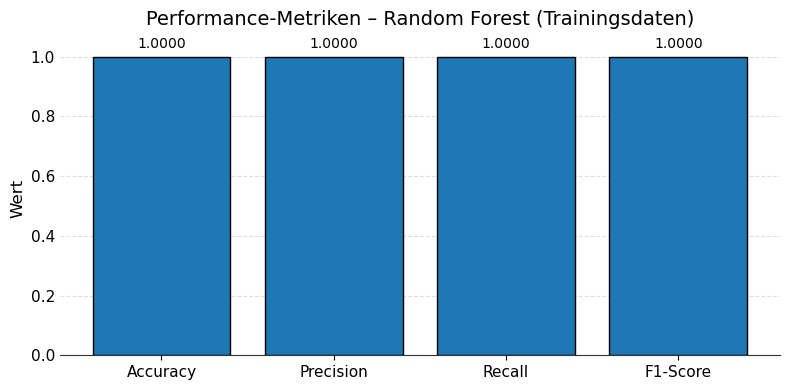

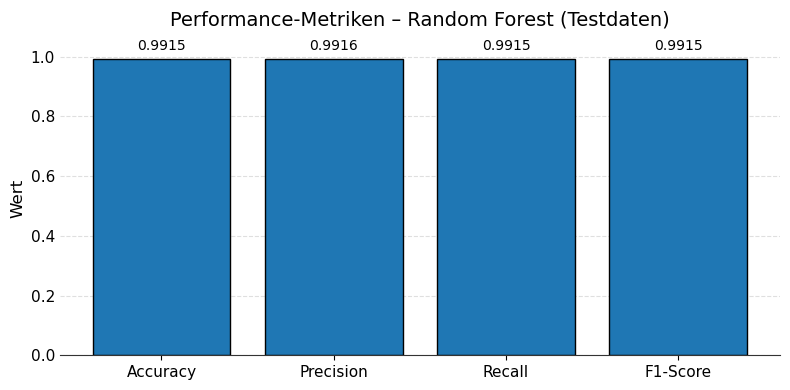

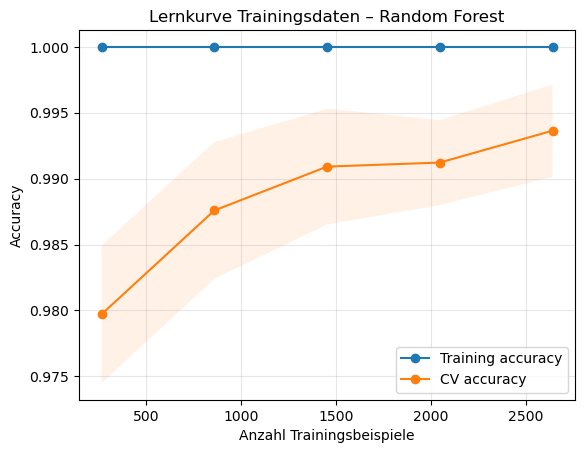

In [18]:
# ---------------------------------------------------------------------------
# 7. Berechnung und Ausgabe von Basis-Metriken - Traindaten
# ---------------------------------------------------------------------------
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
recall_train = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
f1_train = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)

print("\n--- Metriken auf Traindaten ---")
print(f"Accuracy : {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall   : {recall_train:.4f}")
print(f"F1-Score : {f1_train:.4f}")

# Detaillierter Klassifikationsbericht (pro Klasse)
print("\n--- Classification Report (Train) ---")
print(classification_report(y_train, y_train_pred, zero_division=0))

# Konfusionsmatrix anzeigen
cm = confusion_matrix(y_train, y_train_pred)
print("--- Confusion Matrix (Train) ---")
print(cm)

# ---------------------------------------------------------------------------
# 8. Berechnung und Ausgabe von Basis-Metriken - Testdaten
# ---------------------------------------------------------------------------
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
recall_test = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
f1_test = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

print("\n--- Metriken auf Testdaten ---")
print(f"Accuracy : {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall   : {recall_test:.4f}")
print(f"F1-Score : {f1_test:.4f}")

# Detaillierter Klassifikationsbericht (pro Klasse)
print("\n--- Classification Report (Test) ---")
print(classification_report(y_test, y_test_pred, zero_division=0))

# Konfusionsmatrix anzeigen
cm = confusion_matrix(y_test, y_test_pred)
print("--- Confusion Matrix (Test) ---")
print(cm)

# ---------------------------------------------------------------------------
# 9. Balkendiagramm: Accuracy, Precision, Recall, F1-Score
# ---------------------------------------------------------------------------

# Für Trainingsdaten:
utils.plot_performance_metrics(accuracy_train, precision_train, recall_train, f1_train, dataset_name="Trainingsdaten")

# Für Testdaten:
utils.plot_performance_metrics(accuracy_test, precision_test, recall_test, f1_test, dataset_name="Testdaten")

# ---------------------------------------------------------------------------
# 10. Lernkurve erstellen
# ---------------------------------------------------------------------------

# Aufruf der Lernkurven-Funktion mit dem besten Modell und Trainingsdaten
best_model = grid_rf.best_estimator_
utils.plot_learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    title='Lernkurve Trainingsdaten – Random Forest'
)